In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
from CNN import CNN
from dataloader import EmotionDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# Hyperparameter
max_epoch = 1
learning_rate = 0.001
output_dim = 8
device = 'cuda'
BATCH_SIZE = 32

In [ ]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# load datasets
full_data = pd.read_csv('../data/legend.csv')
full_data['label_idx'] = full_data['emotion'].str.lower()

unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)
print(f"Labels: {unique_labels}")

# split data
train_df, val_df = train_test_split(
    full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# create datasets and dataloaders
train_dataset = EmotionDataset(
    train_df, '../images/', transform=data_transform)
val_dataset = EmotionDataset(
    val_df, '../images/', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training samples: 10952, Validation samples: 2738


In [5]:
model = CNN(output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# training
epoch_loss = []
epoch_acc = []
val_loss = []
val_accuracy = []
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # get stat
        running_loss += loss.item() * images.size(0) 

        _, predicted = torch.max(outputs, 1)
        total_prediction += labels.size(0)

        correct_prediction += (predicted == labels).sum().item()

        # if (i + 1) % 5 == 0:
        #     print(
        #         f"[Epoch {epoch+1}/{max_epoch}, Batch {i+1}/{len(dataloader)}] current Loss: {loss.item():.4f}")
    epoch_loss.append(running_loss / len(train_dataset))
    epoch_acc.append(100*correct_prediction/total_prediction)

    # validation check
    model.eval()
    correct = 0
    total = 0
    validation_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            # forward pass during validation
            outputs = model(images)
            # compute validation loss
            loss = criterion(outputs, labels)
            # accumulate validation loss
            validation_loss += loss.item() * images.size(0)

            # get predictions
            _, predicted = torch.max(outputs.data, 1)
            # total number of labels
            total += labels.size(0)
            # count correct predictions
            correct += (predicted == labels).sum().item()

    val_epoch_loss = validation_loss / len(val_dataset)
    accuracy = 100 * correct / total

    val_loss.append(val_epoch_loss)
    val_accuracy.append(accuracy)

    print(
        f"epoch:{epoch}/{max_epoch}, Validation Loss: {val_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("training Done")
torch.save(model.state_dict(), 'emotion_cnn_model.pth')

C:\Users\64698\AppData\Local\Temp\ipykernel_42940\606075545.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
C:\Users\64698\AppData\Local\Temp\ipykernel_42940\606075545.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


epoch:0/1, Validation Loss: 1.0269, Accuracy: 50.15%
training Done


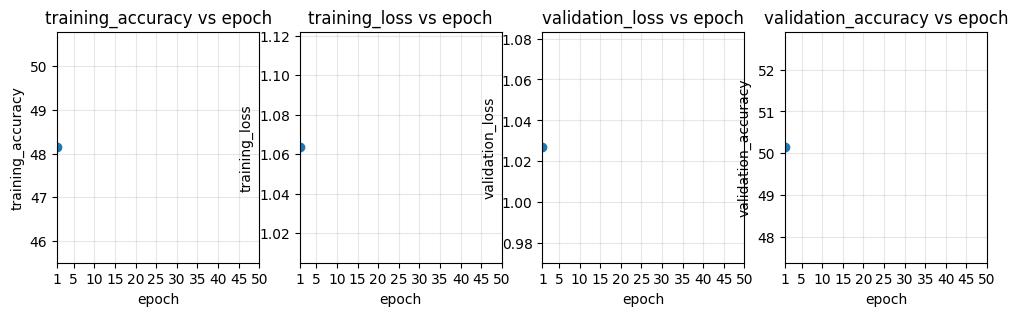

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(range(1, len(epoch_acc)+1), epoch_acc, marker='o')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel("training_accuracy")
axes[0].set_title('training_accuracy vs epoch')
axes[0].set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(epoch_loss)+1), epoch_loss, marker='o')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel("training_loss")
axes[1].set_title('training_loss vs epoch')
axes[1].set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(1, len(val_loss)+1), val_loss, marker='o')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel("validation_loss")
axes[2].set_title('validation_loss vs epoch')
axes[2].set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
axes[2].grid(True, alpha=0.3)

axes[3].plot(range(1, len(val_accuracy)+1), val_accuracy, marker='o')
axes[3].set_xlabel('epoch')
axes[3].set_ylabel("validation_accuracy")
axes[3].set_title('validation_accuracy vs epoch')
axes[3].set_xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
axes[3].grid(True, alpha=0.3)